# Statistical Parameter Estimation 2024

## Special assignment: GPU-enhanced GP Regression with PyTorch

Author: Alex Karonen


Imports and notebook settings


In [2]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

Data creation


In [3]:
N_obs = int(
    1e4
)  # About the maximum reasonable size of observations such that the model fits into my own GPU (RTX 4070)
train_x = torch.linspace(-1, 1, N_obs)
# Ground truth:
sigma = 0.01
theta = [0.1, 0.3, -0.4]
gt = (
    lambda x: theta[0] * torch.sin(100 * x)
    + theta[1] * torch.cos(20 * x)
    + theta[2] * x
) # An arbitrary ground-truth model with some parameters
train_y = gt(train_x) + torch.randn(train_x.size()) * sigma # Noisy training data

Model

In [4]:
# A basic GP model with a constant mean and a squared exponential kernel
class ExactGPModel(gpytorch.models.ExactGP):

    def __init__(self, train_x, train_y, likelihood):

        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()

        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())


    def forward(self, x):

        mean_x = self.mean_module(x)

        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



# initialize likelihood (no prior) and model 
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

Send everything to the GPU


In [5]:
train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

Model training


In [6]:
model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50

def training(model, optimizer, loss_fun, train_x, train_y, max_iters, verbose=True):
    for i in range(max_iters):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -loss_fun(output, train_y)
        loss.backward()
        if verbose:
            print(
                "Iter %d/%d - Loss: %.3f"
                % (
                    i + 1,
                    max_iters,
                    loss.item(),
                )
            )
        optimizer.step()


training(model, optimizer, mll, train_x, train_y, training_iter)

C:\Users\alexk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iter 1/50 - Loss: 0.772
Iter 2/50 - Loss: 0.738
Iter 3/50 - Loss: 0.704
Iter 4/50 - Loss: 0.669
Iter 5/50 - Loss: 0.633
Iter 6/50 - Loss: 0.597
Iter 7/50 - Loss: 0.561
Iter 8/50 - Loss: 0.524
Iter 9/50 - Loss: 0.487
Iter 10/50 - Loss: 0.450
Iter 11/50 - Loss: 0.412
Iter 12/50 - Loss: 0.374
Iter 13/50 - Loss: 0.335
Iter 14/50 - Loss: 0.293
Iter 15/50 - Loss: 0.243
Iter 16/50 - Loss: 0.181
Iter 17/50 - Loss: 0.113
Iter 18/50 - Loss: 0.052
Iter 19/50 - Loss: -0.000
Iter 20/50 - Loss: -0.049
Iter 21/50 - Loss: -0.097
Iter 22/50 - Loss: -0.144
Iter 23/50 - Loss: -0.191
Iter 24/50 - Loss: -0.239
Iter 25/50 - Loss: -0.287
Iter 26/50 - Loss: -0.334
Iter 27/50 - Loss: -0.381
Iter 28/50 - Loss: -0.428
Iter 29/50 - Loss: -0.476
Iter 30/50 - Loss: -0.522
Iter 31/50 - Loss: -0.568
Iter 32/50 - Loss: -0.613
Iter 33/50 - Loss: -0.658
Iter 34/50 - Loss: -0.704
Iter 35/50 - Loss: -0.746
Iter 36/50 - Loss: -0.789
Iter 37/50 - Loss: -0.833
Iter 38/50 - Loss: -0.869
Iter 39/50 - Loss: -0.908
Iter 40/50 - 

Testing

In [7]:
test_x = torch.linspace(-1, 1.5, 1000).cuda()


def predict(model, likelihood, input):
    # Evaluation mode
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(input))
        mean = observed_pred.mean
        lower, upper = observed_pred.confidence_region()
        return mean, lower, upper


mean, lower, upper = predict(model, likelihood, test_x)

Get everything back to CPU for plotting


In [8]:
mean = mean.cpu()
lower = lower.cpu()
upper = upper.cpu()

train_x = train_x.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

Visualize the results


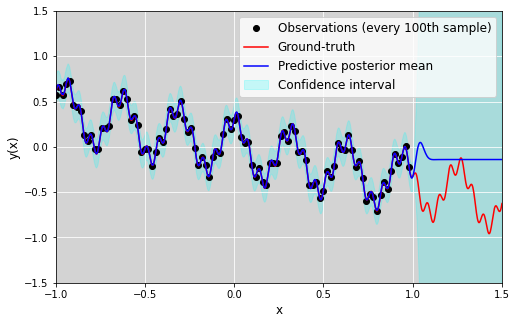

In [15]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.set_facecolor("lightgray")
    ax.grid(c="white")
    # Plot observations
    ax.plot(
        train_x.numpy()[::100],
        train_y.numpy()[::100],
        "k.",
        ms=12,
        label="Observations (every 100th sample)",
    )
    # Plot ground truth
    ax.plot(test_x, gt(test_x), "r", label="Ground-truth")
    # Plot predictive posterior means
    ax.plot(test_x.numpy(), mean.numpy(), "b", label="Predictive posterior mean")
    # Confidence interval
    ax.fill_between(
        test_x.numpy(),
        lower.numpy(),
        upper.numpy(),
        color="cyan",
        alpha=0.2,
        label="Confidence interval",
    )
    ax.legend(loc="upper right", fontsize=12)
    # ax.set_title(f"Predictive posterior on {N_obs} observations", fontsize=20)
    ax.set_ylim([-1.5, 1.5])
    ax.set_xlim([-1, 1.5])
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel(r"y(x)", fontsize=12)

Testing training times between different amounts of observations


In [10]:
import time


N_test = torch.arange(1000, 11000, 1000)


def test_training_times(device):

    Training_times = []
    print(f"Testing on device: {device}")

    for i,N in enumerate(N_test):
        print(f"Test {i+1}/{len(N_test)}")
        # Initialize necessary training data

        train_x = torch.linspace(-1, 1, int(N)).to(device=device)

        train_y = (gt(train_x) + torch.randn(train_x.size()).to(device=device) * sigma).to(device=device)
        if device.type == "cuda":
            likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
            model = ExactGPModel(train_x, train_y, likelihood).cuda()

            loss = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

            optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

            model.train()
            likelihood.train()
            # Initialize cuda kernel event timing tools

            start, stop = torch.cuda.Event(enable_timing=True), torch.cuda.Event(
                enable_timing=True
            )


            # Time the training process
            start.record()
            training(model, optimizer, loss, train_x, train_y, max_iters=50, verbose=False)
            stop.record()
            torch.cuda.synchronize()

            # Save times for plotting

            Training_times.append(start.elapsed_time(stop)*1e-3)  # convert to seconds

        else:

            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            model = ExactGPModel(train_x, train_y, likelihood)

            loss = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

            optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

            model.train()
            likelihood.train()

            start = time.time()


            training(
                model, optimizer, loss, train_x, train_y, max_iters=50, verbose=False
            )
            stop = time.time()


            Training_times.append(
                (stop-start)
            ) 


    return Training_times



cpu_times = test_training_times(torch.device("cpu"))
gpu_times = test_training_times(torch.device("cuda"))

Testing on device: cpu
Test 1/10
Test 2/10
Test 3/10
Test 4/10
Test 5/10
Test 6/10
Test 7/10
Test 8/10


C:\Users\alexk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Test 9/10
Test 10/10
Testing on device: cuda
Test 1/10
Test 2/10
Test 3/10
Test 4/10
Test 5/10
Test 6/10
Test 7/10
Test 8/10
Test 9/10
Test 10/10


Visualize CPU vs GPU training times


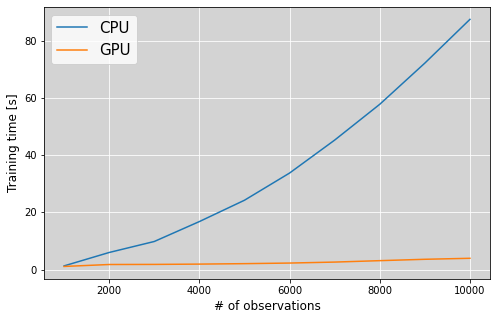

In [11]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_facecolor("lightgray")
ax.grid(c="white")
ax.plot(N_test.numpy(), np.array(cpu_times), label="CPU")
ax.plot(N_test.numpy(), gpu_times, label="GPU")
ax.legend(fontsize=15)
ax.set_xlabel("# of observations", fontsize=12)
ax.set_ylabel("Training time [s]", fontsize=12)

plt.show()